<a href="https://colab.research.google.com/github/SarthakPant01/ds_sarthak_pant/blob/main/notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the modules

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Load Datasets

In [78]:
historical = pd.read_csv('historical_data.csv')
sentiment = pd.read_csv('fear_greed_index.csv')


Clean the column names

In [79]:
historical.columns = (
    historical.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)

sentiment.columns = (
    sentiment.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)


Fixing the timestamps (human readable (in IST))

In [80]:
historical['time'] = pd.to_datetime(
    historical['timestamp_ist'],
    errors='coerce'
)

historical['date'] = historical['time'].dt.date


Fix Numeric Column

In [81]:
num_cols = [
    'closed_pnl',
    'size_tokens',
    'size_usd',
    'fee'
]

for col in num_cols:
    historical[col] = pd.to_numeric(
        historical[col], errors='coerce'
    )


Handling the missing values

In [82]:
historical['closed_pnl'] = historical['closed_pnl'].fillna(0)
historical['fee'] = historical['fee'].fillna(0)

historical = historical[historical['size_tokens'] > 0]


Normalize Text Columns

In [83]:
historical['side'] = historical['side'].str.upper()
historical['direction'] = historical['direction'].str.upper()


Directional Analysis (BUY vs SELL)

In [84]:
side_pnl = (
    historical
    .groupby('side')
    .agg(
        total_pnl=('closed_pnl', 'sum'),
        trades=('trade_id', 'count'),
        avg_pnl=('closed_pnl', 'mean')
    )
)
pd.set_option('display.float_format', '{:.4f}'.format)
side_pnl


,total_pnl,trades,avg_pnl
side,,,
BUY,3707811.3052,102696,36.1047
SELL,6589147.6382,108528,60.7138


DAILY AGGREGATION (CORE DATASET)

In [85]:
daily_pnl = (
    historical
    .groupby('date')
    .agg(
        daily_pnl=('closed_pnl', 'sum'),
        trades=('trade_id', 'count'),
        volume_usd=('size_usd', 'sum'),
        avg_fee=('fee', 'mean')
    )
    .reset_index()
)

daily_pnl.head(10)


,date,daily_pnl,trades,volume_usd,avg_fee
0,2023-01-05,0.0000,3,477.0000,0.0000
1,2023-05-12,0.0000,9,50005.8300,1.3891
2,2024-01-01,-129.5315,18,264239.5300,3.6700
3,2024-01-02,0.0000,6,2008.1800,0.0837
4,2024-01-03,8244.2414,137,472974.7000,-0.0040
5,2024-01-04,2507.9634,77,339470.4700,1.0877
6,2024-01-05,0.0000,14,87025.4500,2.1756
7,2024-01-06,91.5104,25,12834.6200,0.1797
8,2024-01-07,5065.8393,64,362670.1500,6.6457
9,2024-01-08,167.0800,57,227774.5300,1.8964


Performance Labels

In [86]:
daily_pnl['win_day'] = daily_pnl['daily_pnl'] > 0


Equity Curve & Drawdown

In [87]:
daily_pnl['cum_pnl'] = daily_pnl['daily_pnl'].cumsum()
daily_pnl['peak'] = daily_pnl['cum_pnl'].cummax()
daily_pnl['drawdown'] = daily_pnl['cum_pnl'] - daily_pnl['peak']


Risk Metrics

In [88]:
max_drawdown = daily_pnl['drawdown'].min()

sharpe_ratio = (
    daily_pnl['daily_pnl'].mean()
    / daily_pnl['daily_pnl'].std()
) * np.sqrt(252)

max_drawdown, sharpe_ratio


(-122672.000883, np.float64(5.091826292587483))

Visualizations

Equity Curve

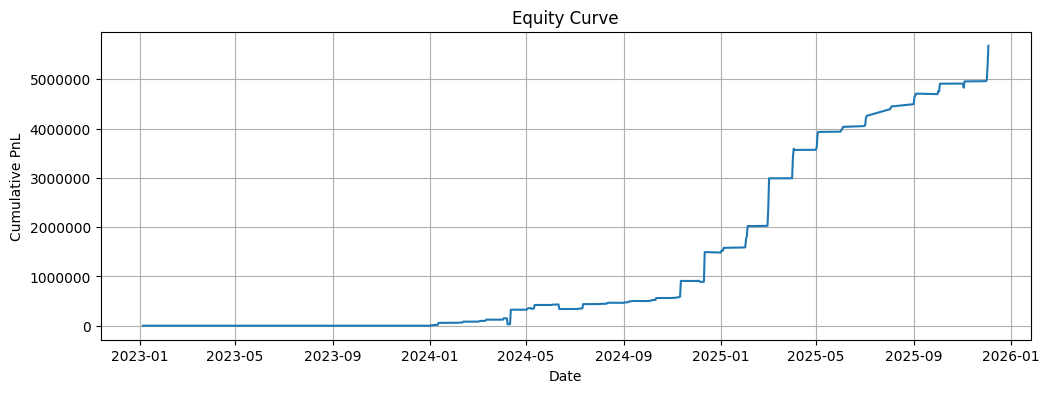

In [89]:
import os
os.makedirs('outputs', exist_ok=True)

plt.figure(figsize=(12, 4))
plt.plot(daily_pnl['date'], daily_pnl['cum_pnl'])
plt.title('Equity Curve')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.grid(True)

plt.ticklabel_format(style='plain', axis='y')
plt.savefig("outputs/equity_curve.png", bbox_inches='tight')
plt.show()



Drawdown

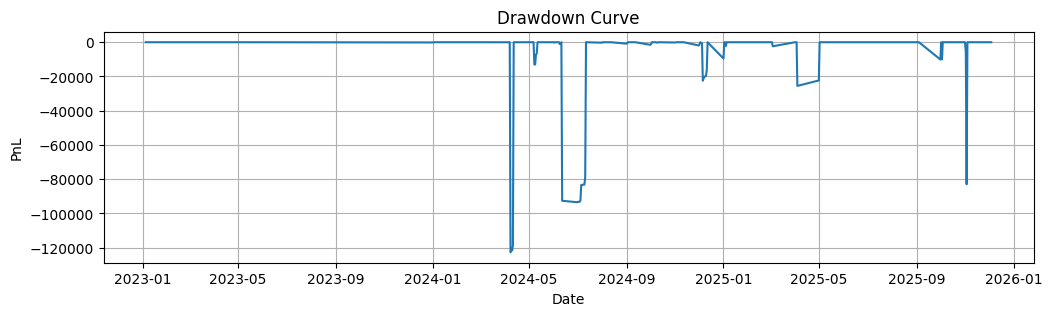

In [90]:
plt.figure(figsize=(12, 3))
plt.plot(daily_pnl['date'], daily_pnl['drawdown'])
plt.title('Drawdown Curve')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.grid(True)
plt.savefig("outputs/dropdown_curve.png", bbox_inches='tight')
plt.show()


Prepare Sentiment Dataset

In [91]:
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date
sentiment['classification'] = sentiment['classification'].str.lower()


Merging the data

In [92]:
merged = daily_pnl.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='inner'
)

merged.head(10)


,date,daily_pnl,trades,volume_usd,avg_fee,win_day,cum_pnl,peak,drawdown,classification
0,2023-01-05,0.0000,3,477.0000,0.0000,False,0.0000,0.0000,0.0000,fear
1,2023-05-12,0.0000,9,50005.8300,1.3891,False,0.0000,0.0000,0.0000,neutral
2,2024-01-01,-129.5315,18,264239.5300,3.6700,False,-129.5315,0.0000,-129.5315,greed
3,2024-01-02,0.0000,6,2008.1800,0.0837,False,-129.5315,0.0000,-129.5315,greed
4,2024-01-03,8244.2414,137,472974.7000,-0.0040,True,8114.7099,8114.7099,0.0000,greed
5,2024-01-04,2507.9634,77,339470.4700,1.0877,True,10622.6734,10622.6734,0.0000,greed
6,2024-01-05,0.0000,14,87025.4500,2.1756,False,10622.6734,10622.6734,0.0000,greed
7,2024-01-06,91.5104,25,12834.6200,0.1797,True,10714.1838,10714.1838,0.0000,greed
8,2024-01-07,5065.8393,64,362670.1500,6.6457,True,15780.0231,15780.0231,0.0000,greed
9,2024-01-08,167.0800,57,227774.5300,1.8964,True,15947.1031,15947.1031,0.0000,greed


SENTIMENT-WISE ANALYSIS

In [93]:
sentiment_summary = (
    merged
    .groupby('classification')
    .agg(
        avg_daily_pnl=('daily_pnl', 'mean'),
        median_daily_pnl=('daily_pnl', 'median'),
        win_rate=('win_day', 'mean'),
        avg_volume=('volume_usd', 'mean'),
        avg_trades=('trades', 'mean'),
        max_drawdown=('drawdown', 'min')
    )
)

pd.set_option('display.float_format', '{:.4f}'.format)

sentiment_summary


,avg_daily_pnl,median_daily_pnl,win_rate,avg_volume,avg_trades,max_drawdown
classification,,,,,,
extreme fear,733.3228,64.5694,0.5000,1596706.6733,387.6667,-2365.9613
extreme greed,26904.5041,541.5547,0.7209,423808.3784,130.7209,-122672.0009
fear,48087.1779,1147.5959,0.7027,2153361.9205,374.8378,-93219.0830
greed,10886.2952,423.0833,0.7143,1018675.2811,201.6429,-92624.6439
neutral,4666.0464,97.7042,0.5625,746221.9506,172.2500,-93460.3251


Visualization: Fear vs Greed

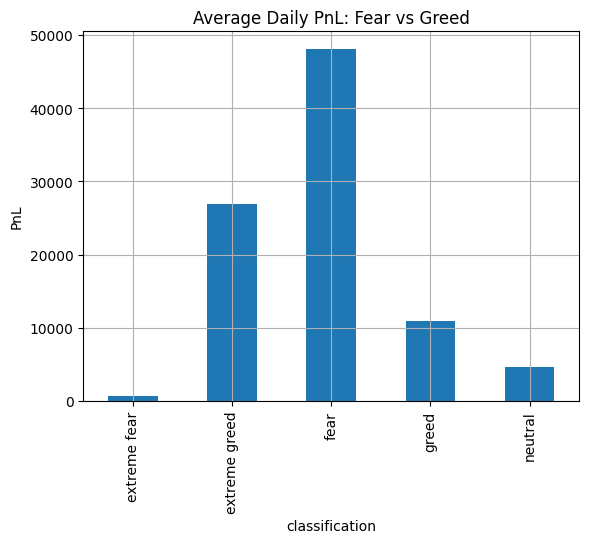

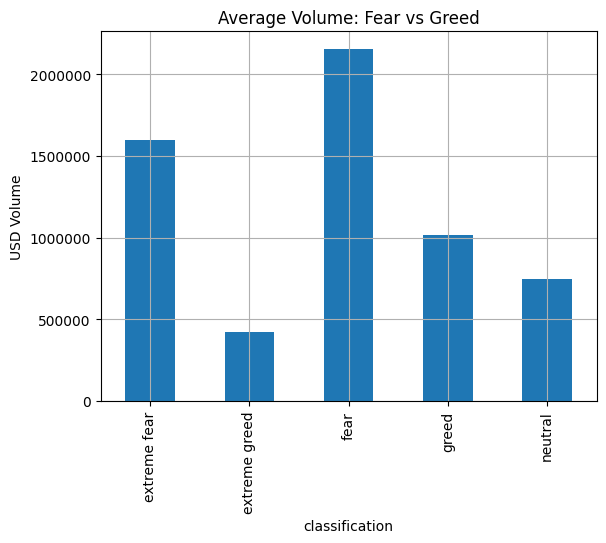

In [94]:
sentiment_summary['avg_daily_pnl'].plot(
    kind='bar',
    title='Average Daily PnL: Fear vs Greed'
)
plt.ylabel('PnL')
plt.grid(True)
plt.savefig("outputs/average_daily_pnl.png", bbox_inches='tight')
plt.show()

sentiment_summary['avg_volume'].plot(
    kind='bar',
    title='Average Volume: Fear vs Greed'
)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('USD Volume')
plt.grid(True)
plt.savefig("outputs/average_volume.png", bbox_inches='tight')
plt.show()


Save Outputs

In [95]:
daily_pnl.to_csv('csv_files/daily_pnl.csv', index=False)
merged.to_csv('csv_files/merged_sentiment.csv', index=False)
